Populating the interactive namespace from numpy and matplotlib
ep= 4.0  tpd= 1.5  tpp= 0.55
set tpd for d3z2r2
set tpd for dx2y2
dim(H) =  3367
start getting ground state
lowest eigenvalue of H = 
[-1.91530465e+00 -5.43497557e-01 -4.18686231e-16 -3.97001615e-16
  4.41556807e-16  1.80449009e+00  1.80787193e+00  1.80787645e+00
  1.81258336e+00  1.81573379e+00]
-1.9153046492320225
starting computing A(w)
ep= 5.0  tpd= 1.5  tpp= 0.55
set tpd for d3z2r2
set tpd for dx2y2
dim(H) =  3367
start getting ground state
lowest eigenvalue of H = 
[-1.65141786e+00 -4.64333377e-01 -2.55679127e-16  2.98142056e-17
  2.51412464e-15  2.80444988e+00  2.80787193e+00  2.80787628e+00
  2.81258336e+00  2.81573377e+00]
-1.6514178616801867
starting computing A(w)
ep= 6.0  tpd= 1.5  tpp= 0.55
set tpd for d3z2r2
set tpd for dx2y2
dim(H) =  3367
start getting ground state
lowest eigenvalue of H = 
[-1.43990039e+00 -4.04544601e-01 -2.15343684e-16  2.47293860e-16
  7.58642722e-16  3.80441194e+00  3.80787193e+00  3.80

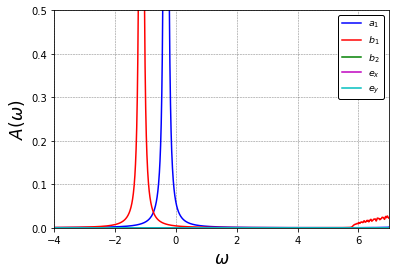

In [1]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
from scipy import integrate
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')

from pylab import *

import timeit
sys.path.append('../../')
import rspace_Norb7 as rspace
from hamiltonian_Norb3or7 import Parameters

M_PI = math.pi 

def write_E_imp(fname,ep,tpd,E_imp):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_E_imp/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\n'.format(ep,tpd,E_imp))
    
def get_ground_state(matrix):       
    print 'start getting ground state'
    # in case eigsh does not work but matrix is actually small, e.g. Mc=1 (CuO4)
    #M_dense = matrix.todense()
    #print 'H='
    #print M_dense
    #vals, vecs = np.linalg.eigh(M_dense)
    #Neval = M_dense.shape[0]
    #print Neval
    
    # in case eigsh works:
    Neval = 10
    vals, vecs = sps.linalg.eigsh(matrix, k=Neval, which='SA')
    vals.sort()
    print 'lowest eigenvalue of H = '
    print vals
    print vals[0]
    return min(vals)

def getAw_peak_lowest(w_vals, Aw):  
    '''
    find the position and weight of lowest peak of Aw, which might be highest
    '''    
    w_idx = 0
    # go through the regime with Aw=0 (numerically ~1.e-6)
    while Aw[w_idx]<1.e-3:
        w_idx += 1
    print 'Aw < 1.e-3 until ', w_vals[w_idx]

    # go up until the peak:
    while Aw[w_idx+1]>Aw[w_idx]:
        w_idx += 1
    w_peak = w_vals[w_idx]
    print 'lowest peak at w = ', w_peak
    
    # find the area below the whole peak, namely the peak weight
    # ==========================================================
    # 1. first find the peak's w-range: [w_min, w_max]
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid-1]>Aw[wid]:
            break
        wid -= 1
    w_min = wid
    
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid+1]>Aw[wid]:
            break
        wid += 1
    w_max = wid
    
    print 'lowest peak w-range = [', w_vals[w_min], w_vals[w_max], ']'
    
    # 2. Simpson's rule
    weight = integrate.simps(Aw[w_min:w_max], w_vals[w_min:w_max])
    print 'lowest peak, weight = ', w_peak, '  ', weight

    return w_peak, weight

def calc_spec_weight_spsolve(ep, tpd, tpp, wmin,wmax):
    wvals = []
    Ga1 = []
    Gb1 = []
    Gb2 = []
    Gex = []
    Gey = []
    Gpx = []
    Gpy = []
    Gpxy = []

    rhs = rspace.create_rhs_matrix()
    w = wmin
    dw = prm.eta/4.0
    dw = 0.005
    static_eom = rspace.create_static_eom_matrix(prm)
    
    E_imp = get_ground_state(static_eom)
    
    print 'starting computing A(w)'
    static_eom = static_eom.tocsc()          
    static_eom.sort_indices()
    sps.linalg.dsolve.use_solver( useUmfpack = True,\
                                  assumeSortedIndices = True )
    while w < wmax:
        eom = rspace.create_eom_matrix(static_eom,w)
        x = sps.linalg.spsolve(eom.tocsc(),rhs).toarray() 
        Ga1.append(x[0,0])
        Gb1.append(x[1,1])
        Gb2.append(x[2,2])
        Gex.append(x[3,3])
        Gey.append(x[4,4])
        Gpx.append(x[rspace.get_index(0,0,0),5])
        Gpy.append(x[rspace.get_index(0,0,1),6])
        Gpxy.append(x[rspace.get_index(10,10,0),7])
        wvals.append(w)
        w += dw
        #print (w-wmin)/(wmax-wmin)

    plt.clf()
    fac = 1.
    plt.plot(wvals,-fac*np.imag(Ga1)/M_PI,'-b',label='$a_1$')
    plt.plot(wvals,-fac*np.imag(Gb1)/M_PI,'-r',label='$b_1$')
    plt.plot(wvals,-fac*np.imag(Gb2)/M_PI,'-g',label='$b_2$')
    plt.plot(wvals,-fac*np.imag(Gex)/M_PI,'-m',label='$e_x$')
    plt.plot(wvals,-fac*np.imag(Gey)/M_PI,'-c',label='$e_y$')
    #plt.plot(wvals,-np.imag(Gpx)/M_PI,'-m',label='px')
    #plt.plot(wvals,-np.imag(Gpy)/M_PI,'-k',label='py')
    #plt.plot(wvals,-np.imag(Gpxy)/M_PI,'-k',label='px far from Cu')
    
    # get the info of lowest peak:
    Aw = -np.imag(Gpxy)/M_PI
    #getAw_peak_lowest(wvals, Aw)
    
    maxval = max(-np.imag(Ga1)/M_PI)
    #title('ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp))
    xlim([-4,7])
    ylim([0,0.5])
    xlabel('$\omega$',fontsize=17)
    ylabel('$A(\omega)$',fontsize=17)
    #text(0.45, 0.1, '(a)', fontsize=16)
    grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
    legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
    savefig('Aw_ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'.pdf')
    
    return E_imp

def calc_spec_weight_bicg(wmin,wmax):
    wvals = []
    gf0 = []
    gf1 = []
    gf2 = []
    rhs0 = rspace.create_rhs_vec(0)
    rhs1 = rspace.create_rhs_vec(1)
    rhs2 = rspace.create_rhs_vec(2)
    w = wmin
    dw = prm.eta/2.0
    static_eom = rspace.create_static_eom_matrix(prm)
    sps.linalg.dsolve.use_solver( useUmfpack = True,\
                                  assumeSortedIndices = True )
    while w < wmax:
        eom = rspace.create_eom_matrix(static_eom,w)
        x0, info = sps.linalg.bicg(eom,rhs0) 
        x1, info = sps.linalg.bicg(eom,rhs1) 
        x2, info = sps.linalg.bicg(eom,rhs2) 
        gf0.append(x0[rspace.get_index(0,0,0)])
        gf1.append(x1[rspace.get_index(0,0,1)])
        gf2.append(x2[rspace.get_index(0,0,2)])
        wvals.append(w)
        w += dw
    #     print (w-wmin)/(wmax-wmin)
    # plt.plot(wvals,-np.imag(gf0)/M_PI,'-r',label='s')
    # plt.plot(wvals,-np.imag(gf1)/M_PI,'-b',label='px')
    # plt.plot(wvals,-np.imag(gf2)/M_PI,'-g',label='py')
    # plt.legend()
    # plt.show()

def calc_spec_weight_pardiso(wmin,wmax):
    wvals = []
    gf0 = []
    gf1 = []
    gf2 = []

    rhs0 = rspace.create_rhs_vec(0)
    rhs1 = rspace.create_rhs_vec(1)
    rhs2 = rspace.create_rhs_vec(2)
    rhs = np.asfortranarray(np.vstack((rhs0,rhs1,rhs2)).T)
    w = wmin
    dw = prm.eta/2.0
    static_eom = rspace.create_static_eom_matrix(prm)
    # static_eom.sort_indices()
    ia = static_eom.indptr+1  # fortran indexing starts at 1
    ja = static_eom.indices+1 # fortran indexing starts at 1
    a = static_eom.data

    pt = np.empty(64, dtype='i8', order='F')
    iparm = np.empty(64, dtype='i4', order='F')
    dparm = np.empty(64, dtype='f8', order='F')
    iparm[2] = 1 # number of processors

    error = pardiso.init(pt, iparm, dparm)
    if error != 0:
        print 'Error in pardiso.init(), ERROR={:d}'.format(error)
    x, error = pardiso.sym_fact(pt,a,ia,ja,iparm,rhs,dparm)
    if error != 0:
        print 'Error in pardiso.sum_fact(), ERROR={:d}'.format(error)
    
    while w < wmax:
        eom = rspace.create_eom_matrix(static_eom,w)
        a = eom.data
        x, error =  pardiso.solve(pt,a,ia,ja,iparm,rhs,dparm)
        if error != 0:
            print 'Error in pardiso.solve(), ERROR={:d}'.format(error)
        gf0.append(x[rspace.get_index(0,0,0),0])
        gf1.append(x[rspace.get_index(0,0,1),1])
        gf2.append(x[rspace.get_index(0,0,2),2])
        wvals.append(w)
        w += dw
    #     print (w-wmin)/(wmax-wmin)
    # plt.plot(wvals,-np.imag(gf0)/M_PI,'-r',label='s')
    # plt.plot(wvals,-np.imag(gf1)/M_PI,'-b',label='px')
    # plt.plot(wvals,-np.imag(gf2)/M_PI,'-g',label='py')
    # plt.legend(loc='upper left')
    # plt.show()

if __name__ == '__main__':  
    rspace.M = 20
    Norb = 7
    tpp = 0.55
    ed = 0
    eta = 0.02
    eps = np.arange(4.0, 8.01, 1.0) #[3.5]#,3.5,4.5]
    
    # or read eps from existing file
    #f1A1 = 'Norb7_tpd0.7_tpp0.55_A6.5_B0.15_C0.58_Upp0_Mc32_eta0.001_1A1.txt'
    #a = loadtxt('../twohole_impurity_model/data_lowpeak/'+f1A1,skiprows=0)
    #eps = a[:,0]
    
    tpds = [1.5]  #np.arange(0.1, 0.11, 0.1)
    
    for ep in eps:
        for tpd in tpds:
            print '==================================================='
            print 'ep=', ep, ' tpd=',tpd,' tpp=',tpp
            fEimp = 'E_imp_Norb'+str(Norb)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_Mc'+str(rspace.M)+'.txt'

            prm = Parameters(Norb,tpd,tpp,ed,ep,eta)
            E_imp = calc_spec_weight_spsolve(ep, tpd, tpp, -10, 20)
            write_E_imp(fEimp,ep,tpd,E_imp)